# PyBaSiC and Ashlar Multichannel
The notebook combines PyBaSiC with Ashlar

### Importing the package

In [1]:
#%pip install basicpy
#%pip install nd2
#%pip install ashlar
#%pip install cv2
#%pip install opencv-python

In [2]:
import os
from basicpy import BaSiC
from basicpy import datasets as bdata
from matplotlib import pyplot as plt
import numpy as np
import nd2
import skimage
import tifffile
import pandas as pd
import cupy as cp

mempool = cp.get_default_memory_pool()
pinned_mempool = cp.get_default_pinned_memory_pool()

ModuleNotFoundError: No module named 'basicpy'

### Reading the input images

In [5]:
base_path = '/media/'
export_path = '/media/'
tmp_path = "/tmp/basic"
%mkdir -p $tmp_path 
os.chdir(base_path)
!ls

FileNotFoundError: [Errno 2] No such file or directory: '/media/'

In [4]:
sampleName = "Antigencycle"
DAPIchannel = 4 #0-based index
outfile = sampleName + ".ome.tif"
##Test {channel} for splitting output into individual colors
infile = sampleName + ".nd2"

In [5]:
infile_array_all = nd2.imread(infile, xarray=True, dask=True)

In [6]:
infile_array_all = nd2.imread(infile)

In [11]:
len(infile_array_all.shape)

4

In [12]:
infile_array_all.shape

(221, 6, 2048, 2048)

In [13]:
#Remove previous flatfield
#if os.path.exists(export_path+'flatfield.tif'):
#    os.unlink(export_path+'flatfield.tif')
#if os.path.exists(export_path+'darkfield.tif'):
#    os.unlink(export_path+'darkfield.tif')

In [14]:
#PyBASiC settings
#from pybasic import settings
#settings.lambda_flatfield = 9.5

#Flatfield regularization parameter (default = 0).
#If you set the flatfield regularization parameter to 0 or a negative value, an internally estimated value is used. We recommend to use internally estimated value. High values (eg. 9.5) increase the spatial regularization strength, yielding a more smooth flat-field. A default value estimated from input images.

#settings.lambda_darkfield = 9.5
#Dark-field regularization parameter (default = 0).

#If you set the darkfield regularization parameter to 0 or a negative value, an internally estimated value is used. We recommend to use internally estimated value. High values (eg. 9.5) increase the spatial regularization strength, yielding a more smooth dark-field. A default value estimated from input images.

#settings.lambda_flatfield

In [15]:
flatfield_stack = []
darkfield_stack = []

if len(infile_array_all.shape) == 4:
    noChannel = infile_array_all.shape[1]
else:
    noChannel = 1
    
for i in range(noChannel):
    print("Running BASiC on channel: " + str((i+1)) + " of " +  str(noChannel))
    #Select channel
    if noChannel == 1:
        infile_array = infile_array_all
    else:
        infile_array = infile_array_all[:,i,:,:]

    #Run PyBaSiC background calculator
    basic = BaSiC(get_darkfield=True, smoothness_flatfield=1)
    basic.fit(infile_array)
    
    #Append Darkfield and Flatfield files 
    flatfield_stack.append(basic.flatfield[None,:])
    darkfield_stack.append(basic.darkfield[None,:])

Running BASiC on channel: 1 of 6
Running BASiC on channel: 2 of 6
Running BASiC on channel: 3 of 6


Reweighting did not converge.


Running BASiC on channel: 4 of 6
Running BASiC on channel: 5 of 6
Running BASiC on channel: 6 of 6


In [16]:
if noChannel == 1:
    tifffile.imwrite(export_path+'flatfield.tif',flatfield)
    tifffile.imwrite(export_path+'darkfield.tif',darkfield)  
else:
    #Merge list into 3D numpy array and save to multi-image tiffs
    tifffile.imwrite(export_path+'flatfield.tif',np.vstack(flatfield_stack))
    tifffile.imwrite(export_path+'darkfield.tif',np.vstack(darkfield_stack))

## Show output flatfield and darkfield components

In [17]:
flatFile = skimage.io.imread(export_path+'flatfield.tif')
flatFile.shape

(6, 2048, 2048)

In [18]:
flatFile.ndim

3

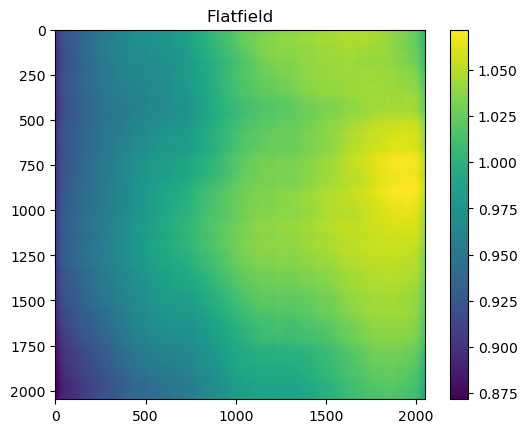

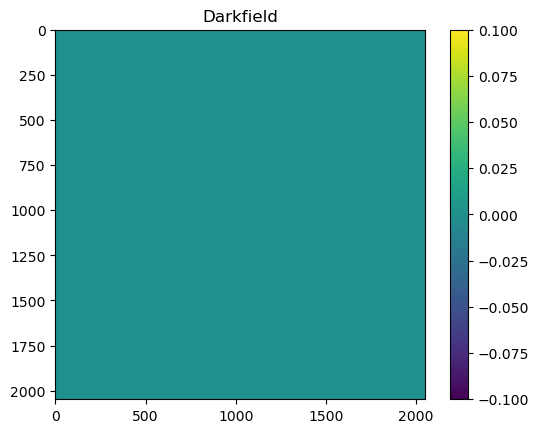

In [19]:
plt.title('Flatfield')
plt.imshow(basic.flatfield)
plt.colorbar()
plt.show()
plt.title('Darkfield')
plt.imshow(basic.darkfield)
plt.colorbar()
plt.show()

## Run Ashlar on the infile with the darkfield and flatfield corrections

In [16]:
args = "--flip-x --flip-y -m 30 --filter-sigma 1 --ffp '" + export_path + "flatfield.tif' --dfp '" + export_path + "darkfield.tif'"

In [17]:
!ashlar --help

usage: ashlar [-h] [-o PATH] [-c CHANNEL] [--flip-x] [--flip-y]
              [--flip-mosaic-x] [--flip-mosaic-y]
              [--output-channels CHANNEL [CHANNEL ...]] [-m SHIFT]
              [--filter-sigma SIGMA] [--tile-size PIXELS]
              [--ffp FILE [FILE ...]] [--dfp FILE [FILE ...]] [--plates] [-q]
              [--version]
              FILE [FILE ...]

Stitch and align multi-tile cyclic microscope images

positional arguments:
  FILE                  Image file(s) to be processed, one per cycle

optional arguments:
  -h, --help            Show this help message and exit
  -o PATH, --output PATH
                        Output file. If PATH ends in .ome.tif a pyramidal OME-
                        TIFF will be written. If PATH ends in just .tif and
                        includes {cycle} and {channel} placeholders, a series
                        of single-channel plain TIFF files will be written. If
                        PATH starts with a relative or absolute pat

In [3]:
call_sequence = "ashlar " + args + " -o '"+ export_path + outfile + "' '" + base_path + infile + "'"
print(call_sequence)
!$call_sequence

NameError: name 'args' is not defined

In [20]:
fullImage = skimage.io.imread(export_path + outfile)
fullImage.shape

(6, 32425, 25191)

In [21]:
fullImageDAPI = fullImage[4,:,:]

# Remove fullImage[5,:,:] from fullImage
fullImage = np.delete(fullImage, 4, 0)

# sum the first dimension of fullImage
fullImageMean = np.sum(fullImage, axis=0)

In [22]:
fullImageDAPI = (fullImageDAPI / (fullImageDAPI.max()) * 255).astype(np.uint8)

In [23]:
fullImageMean = (fullImageMean / (fullImageMean.max()) * 255).astype(np.uint8)

In [24]:
from PIL import Image
rgbArray = np.zeros((fullImageMean.shape[0],fullImageMean.shape[1],3), 'uint8')
rgbArray.shape

(32425, 25191, 3)

In [27]:
#rgbArray[..., 0] = r
rgbArray[..., 1] = fullImageMean
rgbArray[..., 0] = fullImageDAPI
# img = Image.fromarray(rgbArray)
# img.save(export_path + outfile.replace("ome.tif", "RGB_flatRCA.tif"))

#Write a rgb tiff from rgbArray
outfileFlat = outfile.replace("ome.tif", "RGB_flatRCA.tif")

tifffile.imwrite(export_path + outfileFlat, rgbArray)

In [5]:
outfileFlat = outfile.replace("ome.tif", "RGB_flatRCA.tif")

### Generate overlapping tiles

In [4]:
os.chdir(tmp_path)
!ls

NameError: name 'tmp_path' is not defined

In [28]:
import cv2
img = cv2.imread(export_path + outfileFlat)
img_h, img_w, _ = img.shape
split_width = 512
split_height = 512

In [72]:


def start_points(size, split_size, overlap=50):
    points = [0]
    stride = int(split_size * (1-overlap))
    counter = 1
    while True:
        pt = stride * counter
        if pt + split_size >= size:
            if split_size == size:
                break
            points.append(size - split_size)
            break
        else:
            points.append(pt)
        counter += 1
    return points


X_points = start_points(img_w, split_width, 0.5)
Y_points = start_points(img_h, split_height, 0.5)

count = 0
name = 'splitted'
frmt = 'jpeg'

for i in Y_points:
    for j in X_points:
        split = img[i:i+split_height, j:j+split_width]
        cv2.imwrite('{}_{}.{}'.format(name, count, frmt), split)
        count += 1

### Run Cellpose
> Acrivate the Cellpose environment

In [1]:
%cellpose

UsageError: Line magic function `%cellpose` not found.


In [8]:
# edit /home/lcadmin/miniconda3/envs/cellpose/lib/python3.9/site-packages/numpy/lib/format.py
# line 711 to : pickle.dump(array, fp, protocol=4, **pickle_kwargs)
# or use --no_npy

!cellpose --use_gpu --image_path '/media/test.tif' --add_model /tmp/basic/models/CP_20230708_143640 --chan 1 --chan2 0 --diameter 31.9 --save_tif 

>>>> !NEW LOGGING SETUP! To see cellpose progress, set --verbose
No --verbose => no progress or info printed


### Read masks and measure the mean intensity

In [29]:
#%pip install scikit-image
#%pip install pyometiff

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 62.7 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


### Perform Top-Hat background subtraction

In [16]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import skimage
import tifffile
import cupy as cp

In [17]:
fullImage = cp.asarray(skimage.io.imread(export_path + outfile).astype(np.int16))
#fullImage = skimage.io.imread(export_path + outfile).astype(np.uint16)
fullImage.shape

(6, 32425, 25191)

In [18]:
def subtract_background(image, radius=50):
    # import libraries
    from cucim.skimage.morphology import white_tophat, disk
    # generate structuring element
    str_el = disk(radius)

    return white_tophat(image, str_el)

In [19]:
#fullImageBGS = cp.zeros(fullImage.shape, dtype=cp.uint16)
from cucim.skimage.filters import gaussian
for channel in range(fullImage.shape[0]):
    print("Processing channel: " + str(channel))
    fullImageSmooth = gaussian(fullImage[channel,:,:], sigma=10, preserve_range=True)
    fullImageSmoothDetail = subtract_background(fullImageSmooth, radius=75)
    fullImage[channel,:,:] = fullImage[channel,:,:] - (fullImageSmooth - fullImageSmoothDetail)
    del fullImageSmooth
    del fullImageSmoothDetail

Processing channel: 0
Processing channel: 1
Processing channel: 2
Processing channel: 3
Processing channel: 4
Processing channel: 5


In [20]:
fullImage = cp.asnumpy(fullImage)

mempool.free_all_blocks()
pinned_mempool.free_all_blocks()

In [21]:
fullImage[fullImage < 0] = 0

### Subtract remaining tissue background

In [5]:
#del fullImage
fullImage = skimage.io.imread(export_path + sampleName + '_BGS.ome.tif').astype(np.uint16)

In [6]:
#fullImage = fullImageIN.copy()
fullImage.shape

(6, 32425, 25191)

In [118]:
fullImage[i,:,:]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint16)

In [119]:
maxLevel = int(np.percentile(fullImage[i,:,:], 99.999))
maxLevel

1821

In [7]:
bgLevels = [95,25,25,25,15,25] #Background levels for each channel need to be set manually from cortical background measurements

for i in range(6):
    intMTX = fullImage[i,:,:].astype(np.int16) - bgLevels[i]
    maxLevel = int(np.percentile(intMTX, 99.999))
    intMTX[intMTX > maxLevel] = maxLevel
    intMTX = (intMTX / maxLevel * 65535)
    intMTX[intMTX < 0] = 0
    print(np.max(intMTX))
    print(np.min(intMTX))
    fullImage[i,:,:] = intMTX.astype(np.uint16)


65535.0
0.0
65535.0
0.0
65535.0
0.0
65535.0
0.0
65535.0
0.0
65535.0
0.0


In [8]:
i=0
fullImage[i,:,:]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint16)

In [9]:
metadata_dict = {
    "PhysicalSizeX" : "0.88",
    "PhysicalSizeXUnit" : "µm",
    "PhysicalSizeY" : "0.88",
    "PhysicalSizeYUnit" : "µm",
    "PhysicalSizeZ" : "3.3",
    "PhysicalSizeZUnit" : "µm",
    "Channels" : {
        "488" : {
            "Name" : "488nm",
            "SamplesPerPixel": 1,
            "ExcitationWavelength": 488.,
            "ExcitationWavelengthUnit": "nm"
        },
        "554" : {
            "Name" : "Cy3",
            "SamplesPerPixel": 1,
            "ExcitationWavelength": 554.,
            "ExcitationWavelengthUnit": "nm"
        },
        "638" : {
            "Name" : "Cy5",
            "SamplesPerPixel": 1,
            "ExcitationWavelength": 638.,
            "ExcitationWavelengthUnit": "nm"
        },
        "589" : {
            "Name" : "TxRed",
            "SamplesPerPixel": 1,
            "ExcitationWavelength": 589.,
            "ExcitationWavelengthUnit": "nm"
        },
        "405" : {
            "Name" : "DAPI",
            "SamplesPerPixel": 1,
            "ExcitationWavelength": 405.,
            "ExcitationWavelengthUnit": "nm"
        },
        "750" : {
            "Name" : "Ax750",
            "SamplesPerPixel": 1,
            "ExcitationWavelength": 756.,
            "ExcitationWavelengthUnit": "nm"
        },
    }
}

In [10]:
import pathlib
from pyometiff import OMETIFFWriter

dimension_order = "CYX"

writer = OMETIFFWriter(
    fpath=(export_path + sampleName + '_BGS_norm.ome.tif'),
    dimension_order=dimension_order,
    array=fullImage,
    metadata=metadata_dict,
    explicit_tiffdata=False)

writer.write()

### Dilate the masks to cover all transcripts

In [11]:
from skimage.segmentation import expand_labels, watershed

outfileMasks = sampleName + '.RGB_flatRCA_cp_masks.tif'
masks = skimage.io.imread(export_path+outfileMasks)
masks.shape

(32425, 25191)

In [12]:
masksExp = expand_labels(masks, distance=25)

### Measure average intensity per cell

In [13]:
fullImageNo0 = fullImage[:,masksExp > 0]
masksNo0 = masksExp[masksExp > 0]

In [14]:
#Use this instead to only count the nucleus adjescent RCAs
fullImageNo0 = fullImage[:,masks > 0]
masksNo0 = masks[masks > 0]

In [15]:
def extractCellMean(i):
    return np.mean(fullImageNo0[:,masksNo0 == i], axis=1)

In [16]:
# Parallelizing using Pool.apply()

import multiprocessing as mp

# Step 1: Init multiprocessing.Pool()
pool = mp.Pool(mp.cpu_count())

# Step 2: `pool.apply` the `extractCellMean()`
results = pool.map(extractCellMean, [cell for cell in range(1, masksNo0.max()+1)])

# Step 3: Don't forget to close
pool.close()    


In [17]:
cellTable = pd.DataFrame(np.array(results), columns=['Dapi', 'FITC', 'PE'], index=[cell for cell in range(1, masksNo0.max()+1)])
cellTable

,Ax488,Cy3,Cy5,TxRed,DAPI,Ax750
1,350.302932,2166.058632,209.338762,41.478827,2705.856678,22.478827
2,0.144772,0.000000,0.000000,0.000000,5314.690349,47.868633
3,178.486726,1197.109145,52.306785,4747.436578,4917.818584,34.171091
4,517.488673,1101.368123,505.706311,3064.786408,6706.141586,50.504045
5,847.663347,2271.864542,227.135458,334.731076,8768.924303,121.978088
...,...,...,...,...,...,...
49462,79.596100,0.000000,0.000000,0.000000,5733.487465,29.520891
49463,10.466997,0.000000,0.000000,0.000000,6990.678218,23.326733
49464,0.000000,0.000000,0.000000,0.000000,10383.012500,6.362500
49465,122.167382,0.000000,0.000000,0.000000,5510.495708,0.463519


In [18]:
cellTableNorm = cellTable.copy()
cellTableNorm['Dapi'] = (cellTableNorm['Dapi']/cellTableNorm['Dapi'].max()*65535).astype(np.uint16)
cellTableNorm['FITC'] = (cellTableNorm['FITC']/cellTableNorm['FITC'].max()*65535).astype(np.uint16)
cellTableNorm['PE'] = (cellTableNorm['PE']/cellTableNorm['PE'].max()*65535).astype(np.uint16)
#cellTableNorm['TxRed'] = (cellTableNorm['TxRed']/cellTableNorm['TxRed'].max()*65535).astype(np.uint16)
#cellTableNorm['DAPI'] = (cellTableNorm['DAPI']/cellTableNorm['DAPI'].max()*65535).astype(np.uint16)   
#cellTableNorm['Ax750'] = (cellTableNorm['Ax750']/cellTableNorm['Ax750'].max()*65535).astype(np.uint16)


In [19]:
#Write cellTableNorm to pickle file
cellTableNorm.to_pickle(export_path + sampleName + '_cellTableNormNoExp.pkl')
cellTableNorm

,Ax488,Cy3,Cy5,TxRed,DAPI,Ax750
1,350,7623,213,97,3775,26
2,0,0,0,0,7415,56
3,178,4213,53,11154,6861,40
4,517,3876,515,7201,9356,59
5,848,7996,231,786,12234,144
...,...,...,...,...,...,...
49462,79,0,0,0,7999,35
49463,10,0,0,0,9753,27
49464,0,0,0,0,14486,7
49465,122,0,0,0,7688,0


In [20]:
import anndata as ad

In [21]:
#Generate anndata from cellTableNorm
adata = ad.AnnData(cellTableNorm)

/home/lcadmin/miniconda3/envs/cellpose/lib/python3.9/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [22]:
adata.obs

""
1
2
3
4
5
...
49462
49463
49464
49465


In [23]:
adata.write(filename=export_path + sampleName + '_noExp_anndata.gz', compression='gzip')

### Output cell intensity colored cells

In [24]:
#adata = ad.read_h5ad(export_path + sampleName + '_anndata.gz')

In [25]:
#%pip install cupy-cuda11x
import numpy as np
import cupy as cp

In [26]:
masksExp = expand_labels(masks, distance=80) #Expand cells for easier visualization comment out for retaining the analysis masks
masksExp = cp.asarray(masksExp)
masks = cp.asarray(masks)

In [27]:
# cell = 3
# found = np.where(masks == cell)
# fullImageNorm[:,found[0],found[1]] = cellTableNorm.loc[cell].values[:,None]

In [28]:
RCAchannels = list(range(fullImage.shape[0]))
RCAchannels.remove(DAPIchannel)
#RCAchannels = cp.asarray(RCAchannels)


In [29]:
#Create a numpy array with the same dimensions as the fullImage
fullImageNorm = cp.zeros(fullImage.shape, dtype=np.uint16)


In [30]:
for cell in range(1, int(masks.max())+1):
    # Creates a darker outline of the cell
    found = cp.where(masksExp == cell)
    fullImageNorm[:,found[0],found[1]] = (cellTableNorm.loc[cell].values[:,None]*0.5).astype(np.uint16)
    fullImageNorm[DAPIchannel,found[0],found[1]] = 0 
    found = cp.where(masks == cell)
    fullImageNorm[:,found[0],found[1]] = cellTableNorm.loc[cell].values[:,None]


In [31]:
fullImageNorm.shape

(6, 32425, 25191)

In [32]:
fullImageNorm = cp.asnumpy(fullImageNorm)
masksExp = cp.asnumpy(masksExp)
masks = cp.asnumpy(masks)
mempool = cp.get_default_memory_pool()
mempool.free_all_blocks()

In [33]:
metadata_dict = {
    "PhysicalSizeX" : "0.88",
    "PhysicalSizeXUnit" : "µm",
    "PhysicalSizeY" : "0.88",
   
        "405" : {
            "Name" : "DAPI",
            "SamplesPerPixel": 1,
            "ExcitationWavelength": 405.,
            "ExcitationWavelengthUnit": "nm"
        },
        "756" : {
            "Name" : "Cy7",
            "SamplesPerPixel": 1,
            "ExcitationWavelength": 756.,
            "ExcitationWavelengthUnit": "nm"
        },
    }



In [34]:
import pathlib
from pyometiff import OMETIFFWriter

dimension_order = "CYX"

writer = OMETIFFWriter(
    fpath=(export_path + 'testOutput.ome.tif'),
    dimension_order=dimension_order,
    array=fullImageNorm,
    metadata=metadata_dict,
    explicit_tiffdata=False)

writer.write()

In [ ]:
mempool = cp.get_default_memory_pool()
mempool.free_all_blocks()